# INM702 Coursework Task 1 
### Aaron Mir (Student Number: 160001207)
#### 20/12/20

The first task tests your Python skills. You need to develop a simple game consisting of a rectangular grid (of size height x width) where each cell has a random integer value between 0 and 9. An agent starts at the upper-left corner of the grid and must  reach the lower-right corner of the grid as fast as possible. You can implement one of the two (or both, for no extra point) game modes:

    • The time spent on a cell is the number on this cell
    • The time spent on a cell is the absolute of the difference between the previous cell the agent was on and the current cell it is on

In order to solve this problem, you will provide 3 algorithms:

    • A first baseline of your choosing. E.g. it can be any search algorithm, or an algorithm using heuristics. 
    It doesn’t have to perform fast or well, but  should be better than random movements.
    • Dijkstra's algorithm
    • Ant colony optimization algorithm

You should describe the algorithms and compare them. Are they always solving the problem? How long do they take depending on the size of the maze?


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torchvision as tv
import random
import sys
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(1)

print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {tv.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.6.0+cu101
Torchvision Version: 0.7.0+cu101


In [22]:
class Agent():
    '''A class to represent an agent. The goal of the agent is to move along the grid from the upper left corner to the lower right corner using the shortest path possible.'''
    def __init__ (self, name, maze = None):
        self.name = name
        self.maze = maze
        self.curr_position = [0, 0]                                         # this changes according to the current position of the agent after choosing a path and initialises at 0,0 - REDUNDANT RIGHT NOW
        self.position_history = []                                          # holds the history of agent positions, helps verify
        self.options = []                                                   # holds the time values of paths found
        self.option_coords = []                                             # holds the coordinates of each cell in those paths
        self.isFinished = False                                             # changes if agent reaches position bottom right cell, helps verify
        self.chosen_path = 0
        self.paths_taken_by_all_ants = {}                                                                # dictionary to hold all the paths each ant takes in the loop
        self.paths_coords_taken_by_all_ants = {}                                                         # dictionary to hold all the indices of the path each ant takes in the loop
        self.total_time_by_all_ants = {}                                                             # dictionary to hold all the total times each ant takes
        #self.shortest_path_ants_iter = {}                                                                # dictionary to hold all the best paths of an ant per iteration
        self.dijkstra = []                                                                               # holds the shortest path found by dijkstra
#-------------------------------------------------------- NAIVE PATH/SIMPLE RECURSIVE ALGORITHM -----------------------------------------------#
    def recursive_path(self, row, col, paths, coords): 
        '''Uses recursion finds all the possible paths the agent can take to get to the bottom right cell by exploring all paths by moving down and right in the array. Then adds the times spent on each cell for each path and will traverse the path that has the lowest overall time. The current position of the agent is then changed after the comparison is made between different paths.'''                  
        if row == len(self.maze.maze) - 1:                          # if the current row is equal to the height of the maze - 1 
            for i in range(col, len(self.maze.maze[0])):            # for every column from the current column to the edge of the grid going across
                paths.append(self.maze.maze[row][i])                # append all the time values into the path list depending on which row it is currently on
                coords.append((row, i))                             # append all the indexes of those times into the coordinate list of tuples depending on which row it is currently on
            self.options.append(paths)                              # append the possible options to the agent attribute 'options'
            self.option_coords.append(coords)                       # append the coordinates of those possible options to the agent attribute 'option_coords'
            return 

        if col == len(self.maze.maze[0]) - 1:                       # if the current column is equal to the width of the maze - 1 eg. 3 - 1 = 2
            for i in range(row, len(self.maze.maze)):               # for every row from the current row to the edge of the grid going down
                paths.append(self.maze.maze[i][col])                # put all the time values into the path list depending on which column it is currently on
                coords.append((i, col))                             # put all the indexes of those times into the coordinate list of tuples depending on which column it is currently on
            self.options.append(paths)
            self.option_coords.append(coords)
            return
        paths.append(self.maze.maze[row][col])                      # append the time value of the starting cell to path list
        coords.append((row, col))                                   # append the the indexes of that time value coords list
        self.recursive_path(row + 1, col, paths[:], coords[:])      # recursion for each row 
        self.recursive_path(row, col + 1, paths[:], coords[:])      # recursion for each column       
        
        sum_time_vals = np.zeros(len(self.options), dtype=int)      # initialising an array of all the total times for each path
        for i in range(0, len(self.options)):                  
            sum_time_vals[i] = sum(self.options[i])
        self.chosen_path = list(sum_time_vals).index(np.min(sum_time_vals)) # returns index of the shortest path in 'options' 

#-------------------------------------------------------- ANT COLONY OPTIMISATION ALGORITHM (MAIN LOOP IS IN antcol_path METHOD)-----------------------------------------------#
    def fill_initial_pheromones(self, Lij):                  # creates a 2D pheromone array where Lij is the original maze with time values. This sets the initial pheromones = to the attractiveness/desirability of the node
        pheromones = 1/Lij
        pheromones[pheromones==1] = 0.65 
        pheromones[pheromones>1] = 0.70                      # since 0 could be in our grid, 1/0 becomes infinity so we replace this and 1/1 with a lower value to scale the choices ants make  
        return pheromones

    def get_neighbours(self, maze, current_ant_loc):                                        # returns a list of accessible cells to the ant
        neighbours = []                                                                     # contains the up, down, left, right accessible nodes for the ants
        if current_ant_loc[0]-1 >= 0:
            neighbours.append(maze[current_ant_loc[0]-1][current_ant_loc[1]])
        else: neighbours.append(np.NaN)
        if current_ant_loc[0]+1 <= height-1:
            neighbours.append(maze[current_ant_loc[0]+1][current_ant_loc[1]])
        else: neighbours.append(np.NaN)
        if current_ant_loc[1]-1 >= 0:
            neighbours.append(maze[current_ant_loc[0]][current_ant_loc[1]-1])
        else: neighbours.append(np.NaN)
        if current_ant_loc[1]+1 <= width-1:
            neighbours.append(maze[current_ant_loc[0]][current_ant_loc[1]+1])
        else: neighbours.append(np.NaN)
        return neighbours

    def get_neighbours_coords(self, maze, current_ant_loc):                                         # returns a list of accessible cells to the ant, inaccessible ones are replaced with 'Not Possible'
        neighbours_coords = []                                                                      # contains the up, down, left, right accessible nodes for the ants
        if current_ant_loc[0]-1 >= 0:
            neighbours_coords.append([current_ant_loc[0]-1, current_ant_loc[1]])
        else: neighbours_coords.append('Not Possible')
        if current_ant_loc[0]+1 <= height-1:
            neighbours_coords.append([current_ant_loc[0]+1, current_ant_loc[1]])
        else: neighbours_coords.append('Not Possible')
        if current_ant_loc[1]-1 >= 0:
            neighbours_coords.append([current_ant_loc[0], current_ant_loc[1]-1])
        else: neighbours_coords.append('Not Possible')
        if current_ant_loc[1]+1 <= width-1:
            neighbours_coords.append([current_ant_loc[0], current_ant_loc[1]+1])
        else: neighbours_coords.append('Not Possible')
        return neighbours_coords

    def determine_Pij_neighbours(self, pheromones, move_attractiveness, current_ant_loc, path_of_selected_ant_coords, alpha, beta):
        pheromone_neighbours = np.array(self.get_neighbours(pheromones, current_ant_loc))
        attractiveness_neighbours = np.array(self.get_neighbours(move_attractiveness, current_ant_loc))
        pheromone_neighbours_coords = np.array(self.get_neighbours_coords(pheromones, current_ant_loc))
        attractiveness_neighbours_coords = np.array(self.get_neighbours_coords(move_attractiveness, current_ant_loc)) 
        pheromone_times_attractiveness = np.multiply(np.power(pheromone_neighbours, alpha), np.power(attractiveness_neighbours, beta))
        np.nan_to_num(pheromone_times_attractiveness, copy=False, nan=0)                                                            # makes the probability of inaccessible nodes 0     
        return pheromone_times_attractiveness/np.sum(pheromone_times_attractiveness)                                                # gives probabilities of choosing a cell to move to                                                       
    def ant_move(self, neighbour_Pij, neighbours_coords, path_of_selected_ant_coords):
        choice_cell_coords = neighbours_coords[np.random.choice(neighbours_coords.shape[0], 1, False, neighbour_Pij)][0]                      # returns the coords of the chosen cell
        for i in range(len(path_of_selected_ant_coords)):
            if choice_cell_coords[0] == path_of_selected_ant_coords[i][0] and choice_cell_coords[1] == path_of_selected_ant_coords[i][1]:     # checks to see if the chosen cell is in the path already traversed
                while choice_cell_coords[0] == path_of_selected_ant_coords[i][0] and choice_cell_coords[1] == path_of_selected_ant_coords[i][1]:
                   choice_cell_coords = neighbours_coords[np.random.choice(neighbours_coords.shape[0], 1, False, neighbour_Pij)][0]                    # if it is, then choose another move
        new_ant_loc = choice_cell_coords                                                                                                                # update ant location
        return choice_cell_coords, new_ant_loc

    def local_pheromone_update(self, pheromones, initial_pheromones, choice_cell_coords, rho):      # new pheromone value at chosen cell/node
        pheromones[choice_cell_coords[0]][choice_cell_coords[1]] = (1.0-rho) * (pheromones[choice_cell_coords[0]][choice_cell_coords[1]]) 
        + (rho * initial_pheromones[choice_cell_coords[0]][choice_cell_coords[1]])
        return pheromones
    
    def global_pheromone_update(self, pheromones, shortest_path_coords_iter, shortest_path_iter, rho): # global update when iteration has finished (using iteration-best ant)
        for i, j in shortest_path_coords_iter:
            pheromones[i][j] = (1.0-rho) * (pheromones[i][j]) + (rho * (1/(shortest_path_iter)))
        return pheromones

    def antcol_path(self, num_iterations, num_ants, alpha, beta, rho): 
        initial_pheromones = self.fill_initial_pheromones(self.maze.maze)                                               # initial pheromone = the attractivity of each cell - used in the calculation of local pheromone update
        pheromones = initial_pheromones                                                                                 # the 2D array of pheromones at each edge that is changed by ants after local and global updates
        move_attractiveness = initial_pheromones                                                                        # the attractivity of each node - stays the same
        end_condition = [self.maze.height-1, self.maze.width-1]                                                         # ant stops at the bottom-right cell
        for i in range(num_iterations):
            print("The current iteration is", i, "out of", num_iterations-1)
            for j in range(num_ants):
                current_ant_loc = [0,0]
                path_of_selected_ant_coords = []                                                     
                path_of_selected_ant_coords.append(current_ant_loc)                                                             # adds the starting location to the path
                path_of_selected_ant = []
                path_of_selected_ant.append(self.maze.maze[current_ant_loc[0]][current_ant_loc[1]])                             # adds the starting time value to the path

                while np.any(current_ant_loc != end_condition):                                                                 # runs loop until ant reaches bottom right cell
                    neighbours_coords = np.array(self.get_neighbours_coords(self.maze.maze, current_ant_loc))                   # returns array of the indices of the neighbouring cells (up, down, left, right)
                    neighbour_Pij = self.determine_Pij_neighbours(pheromones, move_attractiveness, current_ant_loc, 
                                        path_of_selected_ant_coords, alpha, beta)                                                # returns array of all the probabilities of moving to a neighbour
                    choice_cell_coords, current_ant_loc = self.ant_move(neighbour_Pij, 
                                        neighbours_coords, path_of_selected_ant_coords)                                          # chooses a neighbour using a weighted random choice and updates the current ant location
                    pheromones = self.local_pheromone_update(pheromones, initial_pheromones, choice_cell_coords, rho)            # updates the pheromone level of the cell the ant has moved to.
                    path_of_selected_ant.append(self.maze.maze[choice_cell_coords[0]][choice_cell_coords[1]])                    # contains the time values of the path the ant takes in this loop
                    path_of_selected_ant_coords.append(list(current_ant_loc))                                                    # contains the indices of the path the ant takes in this loop
                                
                time_of_path_of_selected_ant = np.sum(path_of_selected_ant)
                self.total_time_by_all_ants[j] = time_of_path_of_selected_ant                                            # iterates over a dictionary to add the time each ant takes to get to bottom right cell
                self.paths_taken_by_all_ants[j] = path_of_selected_ant                                                           # iterates over a dictionary to add the path of each ant
                self.paths_coords_taken_by_all_ants[j] = path_of_selected_ant_coords                                             # iterates over a dictionary to add the path indices of each ant
            shortest_path_ind_iter = min(self.total_time_by_all_ants, key=self.total_time_by_all_ants.get)               # returns the index (key value) of the shortest path in the dictionary of all paths traversed
            shortest_path_iter = self.total_time_by_all_ants[shortest_path_ind_iter]                                         # returns the time of the shortest path for the iteration
            shortest_path_coords_iter = self.paths_coords_taken_by_all_ants[shortest_path_ind_iter]                              # returns the coords for the shortest path in the dictionary for the iteration
            pheromones = self.global_pheromone_update(pheromones, shortest_path_coords_iter, shortest_path_iter, rho)            # then do global pheromone update using iteration-best path
        self.chosen_path = shortest_path_ind_iter                                                                                # used for plotting the shortest path found over all iterations

#-------------------------------------------------------- DIJKSTRA'S ALGORITHM -----------------------------------------------#    
    def get_neighbours_coords(self, maze, current_loc):                                             # returns a list of accessible cells, inaccessible ones are replaced with 'Not Possible'
        neighbours_coords = []                                                                
        if current_loc[0]-1 >= 0:
            neighbours_coords.append((current_loc[0]-1, current_loc[1]))
        else: neighbours_coords.append('Not Possible')
        if current_loc[0]+1 <= height-1:
            neighbours_coords.append((current_loc[0]+1, current_loc[1]))
        else: neighbours_coords.append('Not Possible')
        if current_loc[1]-1 >= 0:
            neighbours_coords.append((current_loc[0], current_loc[1]-1))
        else: neighbours_coords.append('Not Possible')
        if current_loc[1]+1 <= width-1:
            neighbours_coords.append((current_loc[0], current_loc[1]+1))
        else: neighbours_coords.append('Not Possible')
        return neighbours_coords
    
    def nodes_maze(self, maze):                                                                     # returns a dictionary with nodes as the indices of the cells in the maze and the neighour indices
        nodes = {}
        for i in range(height):
            for j in range(width):
                nodes[(i,j)] = self.get_neighbours_coords(maze, [i,j])
        return nodes
    
    def nodes_times_maze(self, maze):                                                               # returns a dictionary of nodes and the time the agent has to wait on the cell it corresponds to
        nodes_times = {}
        for i in range(height):
            for j in range(width):
                nodes_times[(i,j)] = maze[i][j]
        return nodes_times
    
    def dict_maze(self, nodes, nodes_times):                                                        # returns a dictionary of nodes, the accessible neighbours of that node and the times an agent would spend on the neighbours
        dict_maze = {}
        connected_nodes = {}
        for node in nodes:                  
            for i in nodes[node]:           
                if isinstance(i, tuple):
                    connected_nodes[i] = nodes_times[i]               
            dict_maze[node] = connected_nodes
            connected_nodes = {}
        return dict_maze

    def dijkstra_path(self, start, end): 
        nodes = self.nodes_maze(self.maze.maze)                                                             
        nodes_times = self.nodes_times_maze(self.maze.maze)
        dict_maze = self.dict_maze(nodes, nodes_times)                                              # converts the maze into a dict with nodes:connections to node
        shortest_time = {}                                                                          # tracks the time to reach a particular node, is updated throughout
        track_path = {}                                                                             # tracks the path that led to the node
        non_visited_nodes = dict_maze                                                               # used to iterate through all the nodes
        
        for node in non_visited_nodes:
            shortest_time[node] = np.inf
        shortest_time[start] = nodes_times[start]                                                   # assign each node with infinity except for starting node = cost of (0, 0)

        while non_visited_nodes:                                                                    # does not iterate over visited nodes
            min_time_node = None                                                                     
            for node in non_visited_nodes:
                if min_time_node is None:
                    min_time_node = node
                elif shortest_time[node] < shortest_time[min_time_node]:                            # update minimum time 
                    min_time_node = node
            
            path_options = dict_maze[min_time_node].items()
            for connection, time in path_options:
                if time + shortest_time[min_time_node] < shortest_time[connection]:
                    shortest_time[connection] = time + shortest_time[min_time_node]
                    track_path[connection] = min_time_node
            non_visited_nodes.pop(min_time_node)                                                    # exit the loop by popping the nodes
    
        current_node = end
        while current_node != start:                                                                # used to trace back to the start node
            self.dijkstra.insert(0, current_node)
            current_node = track_path[current_node]
        self.dijkstra.insert(0, start)

        if shortest_time[end] != np.inf:                                                            # this means we have found an appropriate path
            print("The shortest time of path found is ", shortest_time[end])
            print("The shortest path found is ", self.dijkstra)


In [23]:
class IntMaze():
    '''A class to represent a maze. A maze in this scenario is a 2D (height x width) grid where each cell has a number associated to it. This cell number indicates the time an agent spends on a cell. There are 2 game modes. Game mode 1 is where the time spent on a cell is the number on this cell. Game mode 2 is where the time spent on a cell is the absolute of the difference between the previous cell the agent was on and the current cell it is on. 
    Only game mode 1 has been implemented.'''
    def __init__ (self, height, width, mode, alg, agent):  
        self.height = height
        self.width = width
        self.mode = mode
        self.agent = agent
        self.alg = alg
        self.path_find_type = {'Recursive': 0, 'Dijkstra': 1, 'Ant Colony': 2}
    
    def create_maze(self):                                                                                      # generates the grid/map
        return np.array(np.random.randint(0, 10, size = (self.height, self.width)))

    def start_game(self, num_iterations, num_ants, alpha, beta, rho):
        self.maze = self.create_maze()                                                                          # create the grid/maze
        self.agent.maze = self                                                                                  # add agent to the maze/environment
        if self.mode == 1:
            if self.path_find_type[self.alg] == 0:                                                              # Recursive approach
                self.agent.recursive_path(self.agent.curr_position[0], self.agent.curr_position[1], [], []) 
                self.plot_maze_path(annotate=True, chosen_path=True)
            elif self.path_find_type[self.alg] == 1:                                                            # Dijkstra 
                self.agent.dijkstra_path((0,0), (self.height-1, self.width-1))
                self.plot_maze_path(annotate=True, chosen_path=True)
            elif self.path_find_type[self.alg] == 2:                                                            # Antcolony 
                self.agent.antcol_path(num_iterations, num_ants, alpha, beta, rho)
                self.plot_maze_path(annotate=True, chosen_path=True)

    def plot_maze_path(self, annotate, chosen_path): 
        c1 = np.array([0, self.width])
        c2 = np.array([self.height, 0]) 
        dim = len(c1) 
        x_pts = np.linspace(c1[0], c2[0], self.width)
        y_pts = np.linspace(c1[1], c2[1], self.height)
        Xv, Yv = np.meshgrid(x_pts, y_pts)
        numpts = self.width*self.height      
        node_array = np.zeros((numpts, 2), dtype=float)
        node_array[:,0] = np.reshape(Xv, numpts)
        node_array[:,1] = np.reshape(Yv, numpts)
        num_cells = int(self.width-1)*(self.height-1)
        connectivity = np.zeros((num_cells, int(2**dim)), dtype=int)
        rows, cols = self.height-1, self.width-1 
        for row in range(rows):
            for col in range(cols):
                num = self.width*row + col
                connectivity[cols*row + col] = [num+0, num+1, num+self.width, num+self.width+1]

        annotations = self.maze.flatten()
        X,Y = node_array.T
        fig = plt.figure(figsize=(self.width,self.height)) 
        ax = fig.add_subplot(111)
        ax.set_aspect('auto')
        plt.axis('off')
        plt.scatter(X,Y, marker='o', s=50, color='g', alpha=1.0)
        if height == width:
            plt.plot(Xv,Yv, linewidth=2, color='k', alpha=0.2)
            plt.plot(Yv,Xv, linewidth=2, color='k', alpha=0.2)
        if annotate:                    
            for i, pos in enumerate(node_array):
                plt.text(pos[0], pos[1],  str(annotations[i]), color='k', verticalalignment='bottom', horizontalalignment='right', fontsize='xx-large')
            
        nodes_coords = np.split(node_array, self.height)
        
        path_coords_grid = []
        if self.alg == 'Recursive':
            for x, y in self.agent.option_coords[self.agent.chosen_path]:                        # this converts a path to coordinates on the graph depending on what algorithm is chosen
                path_coords_grid.append(nodes_coords[x][y])
        
        if self.alg == 'Ant Colony':
            for x, y in self.agent.paths_coords_taken_by_all_ants[self.agent.chosen_path]: 
                path_coords_grid.append(nodes_coords[x][y])
        
        if self.alg == 'Dijkstra':
            for x, y in self.agent.dijkstra: 
                path_coords_grid.append(nodes_coords[x][y])
        
        head_length = 0.1

        if chosen_path:
            for i in range(len(path_coords_grid)-1): # plots vectors for the shortest path
                dx = path_coords_grid[i+1][0] - path_coords_grid[i][0]
                dy = path_coords_grid[i+1][1] - path_coords_grid[i][1]
                vec_ab = [dx,dy]
                vec_ab_magnitude = np.sqrt(dx**2+dy**2)
                dx = dx / vec_ab_magnitude
                dy = dy / vec_ab_magnitude
                vec_ab_magnitude = vec_ab_magnitude - head_length
                plt.arrow(path_coords_grid[i][0], path_coords_grid[i][1], vec_ab_magnitude*dx, vec_ab_magnitude*dy, head_width=0.1, head_length=0.2, color='red')
        plt.show(block=False)
        return node_array, connectivity

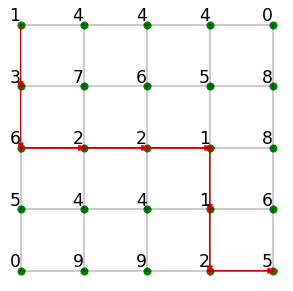

In [74]:
#-------------------------------------------------------- START GAME (NAIVE) -----------------------------------------------#    
height, width = 5,5                                                       # Maze has to be NxN in order for visualisation to work properly
agent_cortez = Agent('Cortez')                                            # Initialise the agent
game = IntMaze(height, width, 1, 'Recursive', agent_cortez)               # Initialise game with maze of height and width, game mode, type of algorithm ('Recursive', 'Ant Colony' or 'Dijkstra') and the agent in the maze
game.start_game(num_iterations=0, num_ants=0, alpha=0, beta=0, rho=0)     # start_game (settings are 0 because this is not ACO)

In [75]:
agent_cortez.options[agent_cortez.chosen_path]      # To see the shortest path found by recursion

[1, 3, 6, 2, 2, 1, 1, 2, 5]

The current iteration is 0 out of 9
The current iteration is 1 out of 9
The current iteration is 2 out of 9
The current iteration is 3 out of 9
The current iteration is 4 out of 9
The current iteration is 5 out of 9
The current iteration is 6 out of 9
The current iteration is 7 out of 9
The current iteration is 8 out of 9
The current iteration is 9 out of 9


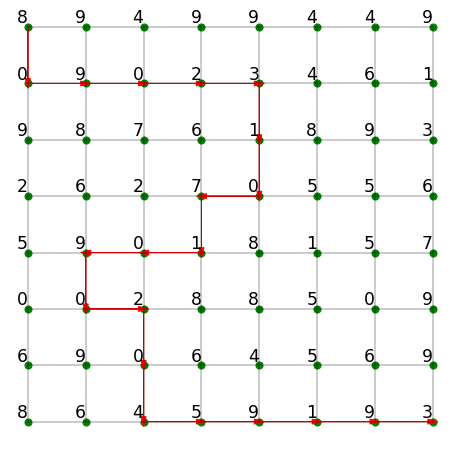

In [85]:
#-------------------------------------------------------- START GAME (ANT-COLONY) -----------------------------------------------#    
height, width = 8,8                                                        # Maze has to be NxN in order for visualisation to work properly
agent_cortez = Agent('Cortez')                                             # Initialise the agent 
game = IntMaze(height, width, 1, 'Ant Colony', agent_cortez)               # Initialise game with maze of height and width, game mode, type of algorithm ('Recursive', 'Ant Colony' or 'Dijkstra') and the agent in the maze
game.start_game(num_iterations=10, num_ants=30, alpha=1, beta=1, rho=0.1)  # rho is the pheromone decay rate     

In [86]:
agent_cortez.paths_taken_by_all_ants[agent_cortez.chosen_path]  # To see the shortest path found by ant colony optimisation

[8, 0, 9, 0, 2, 3, 1, 0, 7, 1, 0, 9, 0, 2, 0, 4, 5, 9, 1, 9, 3]

In [ ]:
agent_cortez.paths_coords_taken_by_all_ants[agent_cortez.chosen_path]  # To see the shortest path found by ant colony optimisation

In [ ]:
agent_cortez.total_time_by_all_ants                         # To see all the paths the ants took OUTPUT BIG depending on how many ants but you can see there is 1 path for each ant and it shows it for the last iteration only

The shortest time of path found is  47
The shortest path found is  [(0, 0), (0, 1), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (7, 4), (7, 5), (7, 6), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]


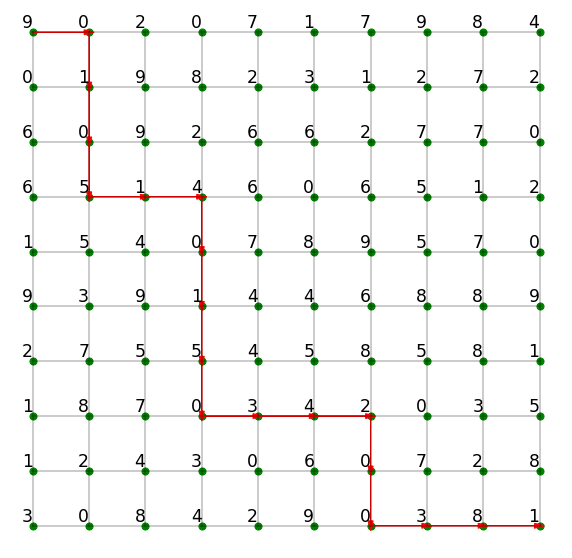

In [24]:
#-------------------------------------------------------- START GAME (DIJKSTRA) -----------------------------------------------#    
height, width = 10,10                                                      # Maze has to be NxN in order for visualisation to work properly
agent_cortez = Agent('Cortez')                                             # Initialise the agent
game = IntMaze(height, width, 1, 'Dijkstra', agent_cortez)                 # Initialise game with maze of height and width, game mode, type of algorithm ('Recursive', 'Ant Colony' or 'Dijkstra') and the agent in the maze
game.start_game(num_iterations=0, num_ants=0, alpha=0, beta=0, rho=0)

## Class Testing Area - No need to look here

In [11]:
class TestAgent():
    def __init__ (self, name, maze = None):
        self.maze = maze
        self.name = name
        #self.i, self.j = 0, 0
        #self.position = [self.i, self.j] # could just index self.position[0] and self.position[1]
        self.curr_position = []         
        self.position_history = []      
        self.options = []               
        self.option_coords = []         
        self.options = []
        self.option_coords = []
        self.isFinished = False
        self.chosen_path = 0  

    def path_Naive(self, row, col, paths, coords, maze): 
        paths.append(maze[row][col])            
        coords.append((row, col))               
        if row == len(maze) - 1:                 
            for i in range(col, len(maze[0])):  
                paths.append(maze[row][i])      
                coords.append((row, i))         
            self.options.append(paths)         
            self.option_coords.append(coords)   
            return 

        if col == len(maze[0]) - 1:             
            for i in range(row, len(maze)):     
                paths.append(maze[i][col])      
                coords.append((i, col))        
            self.options.append(paths)
            self.option_coords.append(coords)
            return
        path_Naive(row + 1, col, paths[:], coords[:], maze) 
        path_Naive(row, col + 1, paths[:], coords[:], maze)       

        sum_time_vals = np.zeros(len(self.options), dtype=int) # will contain an array of all the total times for each path
        for i in range(0, len(self.options)):
            sum_time_vals[i] = sum(self.options[i])
        self.chosen_path = list(sum_time_vals).index(np.min(sum_time_vals))
        # self.options[chosen_path] contains the path chosen
        '''
        for i in range(len(option_coords[chosen_path])):   # now have to change the agents current position according to this path - signifies movement         
            self.curr_position = self.options_coords[chosen_path][i] # need to add some animation on the plot ????
        '''

In [ ]:
class TestMaze():
    def __init__ (self, height, width, mode, alg, agent):  
        self.height = height
        self.width = width
        self.mode = mode
        self.agent = agent
        self.alg = alg
        self.path_find_type = {'Recursive': 0, 'Dijkstra': 1, 'Ant Colony': 2}
    
    def create_maze(self): # generates the grid/map
        return np.array(np.random.randint(0, 10, size = (self.height, self.width)))

    def start_game(self):
        self.maze = self.create_maze()
        self.agent.maze = self # add agent to the maze/environment
        self.agent.maze_disp()

In [ ]:
height, width = 3,3 # Maze has to be NxN in order for visualisation to work
test_agent = TestAgent('Bob')
maze = TestMaze(height, width, 1, 'Recursive', test_agent)
maze.start_game()

## Function Testing Area - No need to look here

In [10]:
height, width = 4, 4
test_maze = np.array([[4, 6, 8, 5],
       [2, 6, 2, 2],
       [0, 8, 8, 4],
       [8, 6, 6, 6]])
options = []
option_coords = []

In [11]:
def test_path_Naive(row, col, paths, coords, maze):
    if row == len(maze) - 1: 
        for i in range(col, len(maze[0])): 
            paths.append(maze[row][i]) 
            coords.append((row, i))
        options.append(paths)
        option_coords.append(coords)
        return 

    if col == len(maze[0]) - 1: 
        for i in range(row, len(maze)): 
            paths.append(maze[i][col])
            coords.append((i, col))
        options.append(paths)
        option_coords.append(coords) 
        return
    paths.append(maze[row][col]) 
    coords.append((row, col)) 
    test_path_Naive(row + 1, col, paths[:], coords[:], maze) 
    test_path_Naive(row, col + 1, paths[:], coords[:], maze) 

    sum_time_vals = np.zeros(len(options), dtype=int)
    for i in range(0, len(options)):
        sum_time_vals[i] = sum(options[i])
    chosen_path = list(sum_time_vals).index(np.min(sum_time_vals))
    return chosen_path

In [12]:
def plot_chosen_path(maze, nx=width, ny=height, annotate=True, show_decided_path=True): 
    c1 = np.array([0, width])
    c2 = np.array([height, 0]) 
    dim = len(c1) 
    x_pts = np.linspace(c1[0], c2[0], nx)
    y_pts = np.linspace(c1[1], c2[1], ny)
    Xv, Yv = np.meshgrid(x_pts, y_pts)
    numpts = nx*ny        
    node_array = np.zeros((numpts, 2), dtype=float)
    node_array[:,0] = np.reshape(Xv, numpts)
    node_array[:,1] = np.reshape(Yv, numpts)
    num_cells = int(nx-1)*(ny-1)
    connectivity = np.zeros((num_cells, int(2**dim)), dtype=int)
    rows, cols = ny-1, nx-1 
    for row in range(rows):
        for col in range(cols):
            num = nx*row + col
            connectivity[cols*row + col] = [num+0, num+1, num+nx, num+nx+1]
        
    annotations = maze.flatten()
    X,Y = node_array.T
    fig = plt.figure(figsize=(nx,ny)) 
    ax = fig.add_subplot(111)
    ax.set_aspect('auto')
    plt.axis('off')
    plt.scatter(X,Y, marker='o', s=50, color='g', alpha=1.0)
    if height == width:
        plt.plot(Xv,Yv, linewidth=2, color='k', alpha=0.2)
        plt.plot(Yv,Xv, linewidth=2, color='k', alpha=0.2)
    if annotate:                    
        for i, pos in enumerate(node_array):
            plt.text(pos[0], pos[1],  str(annotations[i]), color='k', verticalalignment='bottom', horizontalalignment='right', fontsize='xx-large')
        
    nodes_coords = np.split(node_array, ny)
    path_coords_grid = []
    for x, y in option_coords[path]: # this needs to convert a path to coordinates on the graph
        path_coords_grid.append(nodes_coords[x][y])
    head_length = 0.2
    if show_decided_path:
        for i in range(len(path_coords_grid)-1): # plots vectors for the shortest path
            dx = path_coords_grid[i+1][0] - path_coords_grid[i][0]
            dy = path_coords_grid[i+1][1] - path_coords_grid[i][1]
            vec_ab = [dx,dy]
            vec_ab_magnitude = np.sqrt(dx**2+dy**2)
            dx = dx / vec_ab_magnitude
            dy = dy / vec_ab_magnitude
            vec_ab_magnitude = vec_ab_magnitude - head_length
            plt.arrow(path_coords_grid[i][0], path_coords_grid[i][1], vec_ab_magnitude*dx, vec_ab_magnitude*dy, head_width=0.2, head_length=0.2, color='red')
    plt.show(block=False)
    return node_array, connectivity


In [13]:
test_maze

array([[4, 6, 8, 5],
       [2, 6, 2, 2],
       [0, 8, 8, 4],
       [8, 6, 6, 6]])

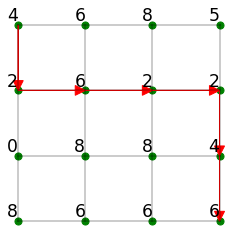

In [14]:
path = test_path_Naive(0,0,[],[],test_maze)
nodes, connectivity = plot_chosen_path(test_maze) # need to add options[path]

In [15]:
options[path]

[4, 2, 6, 2, 2, 4, 6]

In [16]:
option_coords[path]

[(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]

In [ ]:
def antcol_path(self, n_ants, alpha=1, beta=1): 
    for i in range(self.maze.width):
        edge = maze[i]  

In [ ]:
        '''
        for i in range(len(option_coords[chosen_path])):            # changes the agents current position according to this path - signifies movement         
            self.curr_position = self.options_coords[chosen_path][i] 
            # NEED TO ADD SOME ANIMATION TO THE PLOT FUNCTION OF THE MAZE TO SHOW AGENT MOVING AS THE CURRENT POSITION CHANGES

        self.position_history.append(option_coords[chosen_path])    # indicates which cells have been visited by the agent during this traversal i.e. the chosen path
        
        if self.curr_position == self.options_coords[chosen_path][-1]: # verifies that the agent has reached the bottom right
            self.isFinished == True 
        else:
            self.isFinished == False
            print("An error has occurred.")     
        '''

In [ ]:
        '''
        if show_ant_best_paths_per_iter: 
            for i in self.agent.shortest_path_ants_iter:
                ant_paths_coords_grid = []
                for x, y in self.agent.shortest_path_ants_iter[i]: 
                    ant_paths_coords_grid.append(nodes_coords[x][y])
            
            for i in range(len(ant_paths_coords_grid)-1): # plots vectors for the shortest path
                dx = ant_paths_coords_grid[i+1][0] - ant_paths_coords_grid[i][0]
                dy = ant_paths_coords_grid[i+1][1] - ant_paths_coords_grid[i][1]
                vec_ab = [dx,dy]
                vec_ab_magnitude = np.sqrt(dx**2+dy**2)
                dx = dx / vec_ab_magnitude
                dy = dy / vec_ab_magnitude
                vec_ab_magnitude = vec_ab_magnitude - head_length
                plt.arrow(ant_paths_coords_grid[i][0], ant_paths_coords_grid[i][1], vec_ab_magnitude*dx, vec_ab_magnitude*dy, head_width=0.1, head_length=0.2, color='blue')
        '''

In [ ]:
                #current_ant_loc = end_condition
                #choice_cell_coords = end_condition
                #pheromones = self.local_pheromone_update(pheromones, initial_pheromones, choice_cell_coords, rho)                # if loop exits then end condition is satisfied and current ant location is at end
                #path_of_selected_ant.append(self.maze.maze[current_ant_loc[0]][current_ant_loc[1]])                              # adding the time value of last cell
                #path_of_selected_ant_coords.append(current_ant_loc)

In [ ]:
#self.shortest_path_ants_iter[i] = shortest_path_coords_iter                                                         # iterates over a dictionary to add the shortest path found during an iteration       
        #shortest_path_ind_overall = min(self.total_time_by_all_ants, key=self.total_time_by_all_ants.get)           # get the shortest path index after all iterations are complete
        #shortest_path = self.paths_coords_taken_by_all_ants[shortest_path_ind_iter]